# Albumentations
- https://github.com/albumentations-team/albumentations
- 이미지를 쉽게 augmentation 해주는 파이썬 라이브러리
- 다양한 영상변환 알고리즘을 제공하고 있고, 처리 속도도 매우 빨라 딥러닝 전처리용으로 많이 사용
- https://gaussian37.github.io/dl-pytorch-albumentation/

In [5]:
#!pip install albumentations

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import pandas as pd
import numpy as np
import math
import cv2
import albumentations as A
import matplotlib.pyplot as plt

In [63]:
class Augmentation :
    def __init__(self, size, mode='train') :
        if mode == 'train' :
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1*size),
                    max_width=int(0.1*size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
            
    def __call__(self, **kwargs) : # **kwargs : 매개변수의 개수에 상관없이 Dictionary로 바꿔준다.
        if self.transform :
            augmented = self.transform(**kwargs)
            img = augmented['image']
            
            return img

In [73]:
class DataGenerator(keras.utils.Sequence) :
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True) :
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train' :
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val' :
            self.df = self.df[self.df['fold'] == self.fold]
            
            
        #https://github.com/tensorflow/models/issues/3134
        
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
            
        self.on_epoch_end()
    
    # sample() : 전체 row(행)에서 몇 %의 데이터를 return 할 것인지 설정
    # frac : 데이터프레임으로 부터 특정 비율로 무작위 표본 추출을 하고 싶으면 0 ~ 1 사이의 부동소수점을 입력
    # reset_index() : drop = True 옵션을 설정하면 인덱스 열을 보통의 자료열로 설정하는 것이 아니라 버림
    def on_epoch_end(self) :
        if self.shuffle :
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    # len()
    def __len__(self) :
        return math.ceil(len(self.df) / self.batch_size) # ceil 올림
    
    # 클래스의 인덱스 접근할 떄 자동으로 호출되는 메소드
    def __getitem__(self, idx) :
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        data = self.df.iloc[start:end]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    # batch 만큼의 데이터들을 가져온다
    def get_data(self, data) :
        batch_x = []
        batch_y = []
        
        # 데이터 프레임에서 row의 개수만큼 반복
        # 튜플로 리턴(index, 행정보(Series))
        
        for _, r in data.iterrows() :
            file_name = r['file_name']
            image = cv2.imread(f'1_data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            
            if self.mode == 'train' :
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image/255.
            
            label = int(r['species']) -1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

In [74]:
#import os
#os.getcwd()
#os.chdir("/Users/woojaejoo/Code/파이썬으로 만드는 인공지능 코드/강남 IT")

In [75]:
csv_path = './1_data/kfolds.csv'

#def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True)
train_generator = DataGenerator(
    batch_size = 64,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 64,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

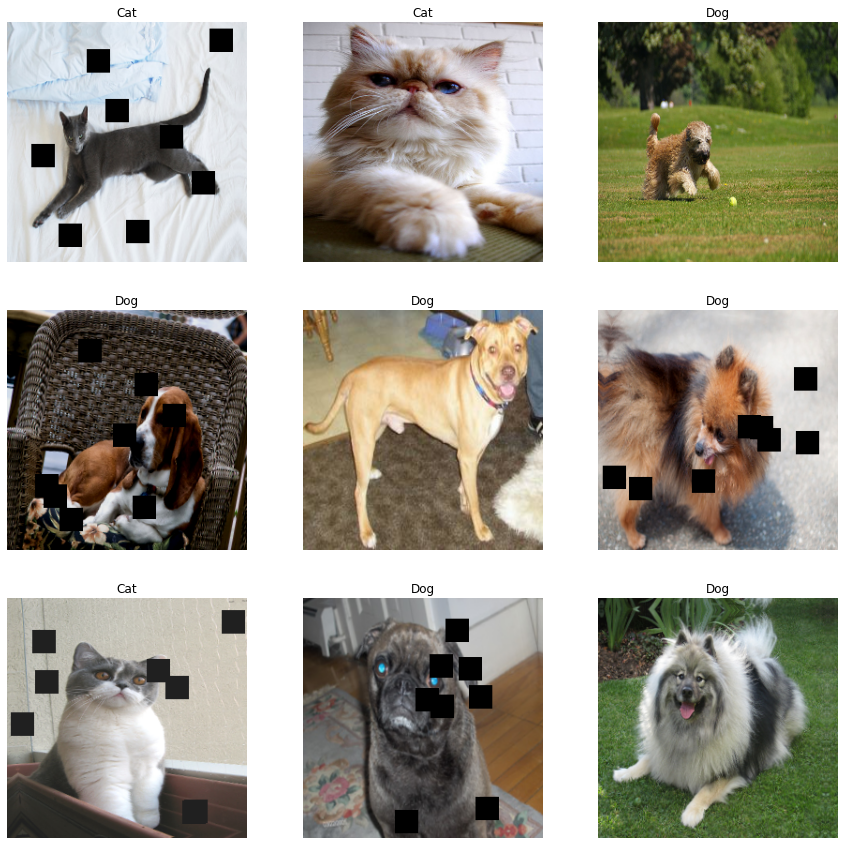

In [78]:
class_name = ['Cat', 'Dog']


for batch in train_generator : # 부모 클래스의 상속으로인해 한 배치씩 데이터를 넘겨준다.
    X, y = batch
    plt.figure(figsize=(15,15))
    
    for i in range(9) :
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
        
    break

In [79]:
# padding='same' 텐서플로우가 자동으로 패딩을 삽입해서 입력값과 출력값의 크기를 맞춰준다
# padding='valid' 텐서플로우가 자동으로 패딩을 적용하지 않고 필터를 적용해서 출력값의 크기가 작아짐
# 

def get_sequential_model(input_shape) :
    model = keras.Sequential(
        [
            layers.Input(input_shape),
            
            # 1st
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # 2nd
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            # FC
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
            
        ]
    )
    return model

In [82]:
input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)    

In [83]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2022-06-05 16:09:14.050552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 16:09:14.351866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.6562

2022-06-05 16:10:03.487564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 54s 551ms/step - loss: 0.7213 - accuracy: 0.6562 - val_loss: 0.6281 - val_accuracy: 0.6778
Epoch 2/10
92/92 [==============================] - 50s 544ms/step - loss: 0.6474 - accuracy: 0.6589 - val_loss: 0.6371 - val_accuracy: 0.6778
Epoch 3/10
92/92 [==============================] - 50s 542ms/step - loss: 0.6301 - accuracy: 0.6739 - val_loss: 0.6238 - val_accuracy: 0.6785
Epoch 4/10
92/92 [==============================] - 50s 538ms/step - loss: 0.6321 - accuracy: 0.6674 - val_loss: 0.6333 - val_accuracy: 0.6812
Epoch 5/10
92/92 [==============================] - 49s 534ms/step - loss: 0.6237 - accuracy: 0.6749 - val_loss: 0.6285 - val_accuracy: 0.6805
Epoch 6/10
92/92 [==============================] - 50s 545ms/step - loss: 0.6305 - accuracy: 0.6660 - val_loss: 0.6561 - val_accuracy: 0.6812
Epoch 7/10
92/92 [==============================] - 52s 560ms/step - loss: 0.6243 - accuracy: 0.6708 - val_loss: 0.6071 - val_accuracy: 0.6812
Epoch 8/10

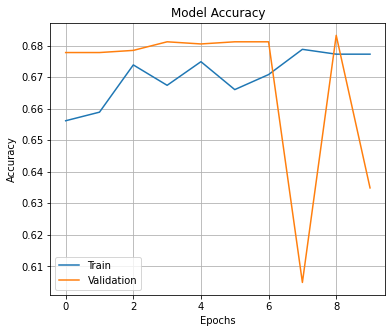

In [93]:
plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()